# Model interpretation for Visual Question Answering


In this notebook we demonstrate how to apply model interpretability algorithms from captum library on VQA models. More specifically we explain model predictions by applying integrated gradients on a small sample of image-question pairs. More details about Integrated gradients can be found in the original paper: https://arxiv.org/pdf/1703.01365.pdf

As a reference VQA model we use the following open source implementation:
https://github.com/Cyanogenoid/pytorch-vqa
  
  **Note:** Before running this tutorial, please install the `torchvision`, `PIL`, and `matplotlib` packages.

In [144]:
# !git clone https://github.com/Cyanogenoid/pytorch-vqa.git
# !git clone https://github.com/Cyanogenoid/pytorch-resnet.git
# !wget 'https://github.com/Cyanogenoid/pytorch-vqa/releases/download/v1.0/2017-08-04_00.55.19.pth'

In [197]:
import os, sys

sys.path.append("pytorch-vqa/")
sys.path.append("pytorch-resnet/")

In [232]:
import threading
import numpy as np

import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F

import resnet  # from pytorch-resnet

import matplotlib.pyplot as plt
from PIL import Image
from matplotlib.colors import LinearSegmentedColormap

from model import Net, apply_attention, tile_2d_over_nd # from pytorch-vqa
from utils import get_transform # from pytorch-vqa

from captum.attr import (
    IntegratedGradients,
    LayerIntegratedGradients,
    Saliency,
    TokenReferenceBase,
    GuidedGradCam,
    LayerGradCam,
    LayerAttribution,
    Deconvolution,
    configure_interpretable_embedding_layer,
    remove_interpretable_embedding_layer,
    visualization
)
from captum.attr._utils.input_layer_wrapper import ModelInputWrapper

In [199]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Loading VQA model

VQA model can be downloaded from: 
https://github.com/Cyanogenoid/pytorch-vqa/releases/download/v1.0/2017-08-04_00.55.19.pth

In [200]:
saved_state = torch.load('2017-08-04_00.55.19.pth', map_location=device)
# reading vocabulary from saved model
vocab = saved_state['vocab']

# reading word tokens from saved model
token_to_index = vocab['question']

# reading answers from saved model
answer_to_index = vocab['answer']

num_tokens = len(token_to_index) + 1

# reading answer classes from the vocabulary
answer_words = ['unk'] * len(answer_to_index)
for w, idx in answer_to_index.items():
    answer_words[idx]=w


Loads predefined VQA model and sets it to eval mode.
`device_ids` contains a list of GPU ids which are used for paralelization supported by `DataParallel`

In [201]:
vqa_net = torch.nn.DataParallel(Net(num_tokens))
vqa_net.load_state_dict(saved_state['weights'])
vqa_net.to(device)
vqa_net.eval()

/Users/jasoncyuan/vqa/pytorch-vqa/model.py:86: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  init.xavier_uniform(self.embedding.weight)
/Users/jasoncyuan/vqa/pytorch-vqa/model.py:44: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  init.xavier_uniform(m.weight)


DataParallel(
  (module): Net(
    (text): TextProcessor(
      (embedding): Embedding(15193, 300, padding_idx=0)
      (drop): Dropout(p=0.5, inplace=False)
      (tanh): Tanh()
      (lstm): LSTM(300, 1024)
    )
    (attention): Attention(
      (v_conv): Conv2d(2048, 512, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (q_lin): Linear(in_features=1024, out_features=512, bias=True)
      (x_conv): Conv2d(512, 2, kernel_size=(1, 1), stride=(1, 1))
      (drop): Dropout(p=0.5, inplace=False)
      (relu): ReLU(inplace=True)
    )
    (classifier): Classifier(
      (drop1): Dropout(p=0.5, inplace=False)
      (lin1): Linear(in_features=5120, out_features=1024, bias=True)
      (relu): ReLU()
      (drop2): Dropout(p=0.5, inplace=False)
      (lin2): Linear(in_features=1024, out_features=3000, bias=True)
    )
  )
)

Converting string question into a tensor. `encode_question` function is similar to original implementation of `encode_question` method in pytorch-vqa source code.
https://github.com/Cyanogenoid/pytorch-vqa/blob/master/data.py#L110



In [202]:
def encode_question(question):
    """ Turn a question into a vector of indices and a question length. Unrecognized turned into 0."""
    question_arr = question.lower().split()
    vec = torch.zeros(len(question_arr), device=device).long()
    for i, token in enumerate(question_arr):
        index = token_to_index.get(token, 0)
        vec[i] = index
    return vec, torch.tensor(len(question_arr), device=device)

# Defining end-to-end VQA model

Original saved model does not have image network's (resnet's) layers attached to it. We attach it in the below cell using forward-hook. The rest of the model is identical to the original definition of the model: https://github.com/Cyanogenoid/pytorch-vqa/blob/master/model.py#L48

In [203]:
class ResNetLayer4(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.r_model = resnet.resnet152(pretrained=True) # [18, 34, 50, 101, 150]
        self.r_model.eval()
        self.r_model.to(device)

        self.buffer = {}
        lock = threading.Lock()

        # Since we only use the output of the 4th layer from the resnet model and do not
        # need to do forward pass all the way to the final layer we can terminate forward
        # execution in the forward hook of that layer after obtaining the output of it.
        # For that reason, we can define a custom Exception class that will be used for
        # raising early termination error.
        def save_output(module, input, output):
            with lock:
                self.buffer[output.device] = output

        self.r_model.layer4.register_forward_hook(save_output)

    def forward(self, x):
        self.r_model(x)          
        return self.buffer[x.device]

class VQA_Resnet_Model(Net):
    def __init__(self, embedding_tokens):
        super().__init__(embedding_tokens)
        self.resnet_layer4 = ResNetLayer4()
    
    def forward(self, v, q, q_len):
        q = self.text(q, list(q_len.data))
        v = self.resnet_layer4(v)

        v = v / (v.norm(p=2, dim=1, keepdim=True).expand_as(v) + 1e-8)

        a = self.attention(v, q)
        v = apply_attention(v, a)

        combined = torch.cat([v, q], dim=1)
        answer = self.classifier(combined)
        return answer

In order to explain text features, we must let integrated gradients attribute on the embeddings, not the indices. The reason for this is simply due to Integrated Gradients being a gradient-based attribution method, as we are unable to compute gradients with respect to integers.

Hence, we have two options:
1. "Patch" the model's embedding layer and corresponding inputs. To patch the layer, use the `configure_interpretable_embedding_layer`^ method, which will wrap the associated layer you give it, with an identity function. This identity function accepts an embedding and outputs an embedding. You can patch the inputs, i.e. obtain the embedding for a set of indices, with `model.wrapped_layer.indices_to_embeddings(indices)`.
2. Use the equivalent layer attribution algorithm (`LayerIntegratedGradients` in our case) with the utility class `ModelInputWrapper`. The `ModelInputWrapper` will wrap your model and feed all it's inputs to seperate layers; allowing you to use layer attribution methods on inputs. You can access the associated layer for input named `"foo"` via the `ModuleDict`: `wrapped_model.input_maps["foo"]`.

^ NOTE: For option (1), after finishing interpretation it is important to call `remove_interpretable_embedding_layer` which removes the Interpretable Embedding Layer that we added for interpretation purposes and sets the original embedding layer back in the model.

Below I am using the `USE_INTEPRETABLE_EMBEDDING_LAYER` flag to do option (1) if it is True, otherwise (2) if it is False. Generally it is reccomended to do option (2) since this option is much more flexible and easy to use. The reason it is more flexible is it allows your model to do any sort of preprocessing to the indices tensor. It's easier to use since you don't have to touch your inputs.

In [205]:
USE_INTEPRETABLE_EMBEDDING_LAYER = False  # set to True for option (1)

Updating weights from the saved model and removing the old model from the memory. And wrap the model with `ModelInputWrapper`.

In [206]:
vqa_resnet = VQA_Resnet_Model(vqa_net.module.text.embedding.num_embeddings)

# wrap the inputs into layers incase we wish to use a layer method
vqa_resnet = ModelInputWrapper(vqa_resnet)

# `device_ids` contains a list of GPU ids which are used for paralelization supported by `DataParallel`
vqa_resnet = torch.nn.DataParallel(vqa_resnet)

# saved vqa model's parameters
partial_dict = vqa_net.state_dict()

state = vqa_resnet.module.state_dict()
state.update(partial_dict)
vqa_resnet.module.load_state_dict(state)

vqa_resnet.to(device)
vqa_resnet.eval()

# This is original VQA model without resnet. Removing it, since we do not need it
del vqa_net


/Users/jasoncyuan/vqa/pytorch-vqa/model.py:86: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  init.xavier_uniform(self.embedding.weight)
/Users/jasoncyuan/vqa/pytorch-vqa/model.py:44: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  init.xavier_uniform(m.weight)


Patch the model's embedding layer if we're doing option (1)

In [207]:
if USE_INTEPRETABLE_EMBEDDING_LAYER:
    interpretable_embedding = configure_interpretable_embedding_layer(vqa_resnet, 'module.module.text.embedding')

Below function will help us to transform and image into a tensor.

In [208]:
image_size = 448  # scale image to given size and center
central_fraction = 1.0

transform = get_transform(image_size, central_fraction=central_fraction)
    
def image_to_features(img):
    img_transformed = transform(img)
    img_batch = img_transformed.unsqueeze(0).to(device)
    return img_batch

/Users/jasoncyuan/miniconda3/envs/captum/lib/python3.9/site-packages/torchvision/transforms/transforms.py:279: UserWarning: The use of the transforms.Scale transform is deprecated, please use transforms.Resize instead.
  warnings.warn("The use of the transforms.Scale transform is deprecated, " +


Creating reference aka baseline / background for questions. This is specifically necessary for baseline-based model interpretability algorithms. In this case for integrated gradients. More details can be found in the original paper: https://arxiv.org/pdf/1703.01365.pdf

In [209]:
PAD_IND = token_to_index['pad']
token_reference = TokenReferenceBase(reference_token_idx=PAD_IND)

In [210]:
# this is necessary for the backpropagation of RNNs models in eval mode
torch.backends.cudnn.enabled=False

Creating an instance of layer integrated gradients for option (2); otherwise create an instance of integrated gradients for option (1). Both are equivalent methods to interpret the model's outputs.

In [211]:
if USE_INTEPRETABLE_EMBEDDING_LAYER:
    # attr = IntegratedGradients(vqa_resnet)
    # attr = Saliency(vqa_resnet)
    # attr = GuidedGradCam(vqa_resnet, vqa_resnet.module.module.resnet_layer4.r_model.layer4)
    # attr = Deconvolution(vqa_resnet)
    assert(0)
else:
    # attr = LayerIntegratedGradients(vqa_resnet, [vqa_resnet.module.input_maps["v"], vqa_resnet.module.module.text.embedding])
    attr = LayerGradCam(vqa_resnet, vqa_resnet.module.module.resnet_layer4.r_model.layer4)

Defining default cmap that will be used for image visualizations 

In [212]:
default_cmap = LinearSegmentedColormap.from_list('custom blue', 
                                                 [(0, '#ffffff'),
                                                  (0.25, '#252b36'),
                                                  (1, '#000000')], N=256)


Defining a few test images for model intepretation purposes

In [213]:
# !wget https://nitrocdn.com/mwIJloVUffDtKiCgRcivopdgojcJrVwT/assets/static/optimized/rev-3131a8b/image/siamese-cat-cover.jpg -O siamese.jpg
# !wget https://s.abcnews.com/images/International/MChanga_1624536553868_hpMain_4x5_992.jpg -O elephant.jpg
# !wget https://cdn.mos.cms.futurecdn.net/HjFE8NKWuCmgfHCcndJ3rK-480-80.jpg -O zebra.jpg

In [214]:
images = ['siamese.jpg',
          'elephant.jpg',
          'zebra.jpg',
          'catdog.jpg']

In [256]:
def vqa_resnet_interpret(image_filename, questions, targets):
    img = Image.open(image_filename).convert('RGB')
    original_image = transforms.Compose([transforms.Scale(int(image_size / central_fraction)),
                                   transforms.CenterCrop(image_size), transforms.ToTensor()])(img) 
    
    image_features = image_to_features(img).requires_grad_().to(device)
    for question, target in zip(questions, targets):
        q, q_len = encode_question(question)
        
        # generate reference for each sample
        q_reference_indices = token_reference.generate_reference(q_len.item(), device=device).unsqueeze(0)

        inputs = (q.unsqueeze(0), q_len.unsqueeze(0))
        if USE_INTEPRETABLE_EMBEDDING_LAYER:
            q_input_embedding = interpretable_embedding.indices_to_embeddings(q).unsqueeze(0)
            q_reference_baseline = interpretable_embedding.indices_to_embeddings(q_reference_indices).to(device)

            inputs = (image_features, q_input_embedding)
            baselines = (image_features * 0.0, q_reference_baseline)
            
        else:            
            inputs = (image_features, q.unsqueeze(0))
            baselines = (image_features * 0.0, q_reference_indices)
            
        ans = vqa_resnet(*inputs, q_len.unsqueeze(0))
            
        # Make a prediction. The output of this prediction will be visualized later.
        pred, answer_idx = F.softmax(ans, dim=1).data.cpu().max(dim=1)

        attributions = attr.attribute(inputs=inputs,
                                    # baselines=baselines,
                                    target=answer_idx,
                                    additional_forward_args=q_len.unsqueeze(0),
                                    # n_steps=8
                                    )

        attributions = LayerAttribution.interpolate(attributions, (448, 448))

        # print(attributions.shape)
        # Visualize text attributions
        # text_attributions_norm = attributions[1].sum(dim=2).squeeze(0).norm()
        # vis_data_records = [visualization.VisualizationDataRecord(
        #                         attributions[1].sum(dim=2).squeeze(0) / text_attributions_norm,
        #                         pred[0].item(),
        #                         answer_words[ answer_idx ],
        #                         answer_words[ answer_idx ],
        #                         target,
        #                         attributions[1].sum(),       
        #                         question.split(),
        #                         0.0)]
        # visualization.visualize_text(vis_data_records)

        # visualize image attributions
        original_im_mat = np.transpose(original_image.cpu().detach().numpy(), (1, 2, 0))
        attributions_img = np.reshape(attributions.detach().cpu().numpy(), (448, 448, 1))

        
        visualization.visualize_image_attr_multiple(attributions_img, original_im_mat, 
                                                    ["original_image", "heat_map"], ["all", "absolute_value"], 
                                                    titles=["Original Image", "Attribution Magnitude"],
                                                    cmap=default_cmap,
                                                    show_colorbar=True)
        # print('Text Contributions: ', attributions[1].sum().item())
        # print('Image Contributions: ', attributions[0].sum().item())
        # print('Total Contribution: ', attributions[0].sum().item() + attributions[1].sum().item())


/Users/jasoncyuan/miniconda3/envs/captum/lib/python3.9/site-packages/torchvision/transforms/transforms.py:279: UserWarning: The use of the transforms.Scale transform is deprecated, please use transforms.Resize instead.
  warnings.warn("The use of the transforms.Scale transform is deprecated, " +


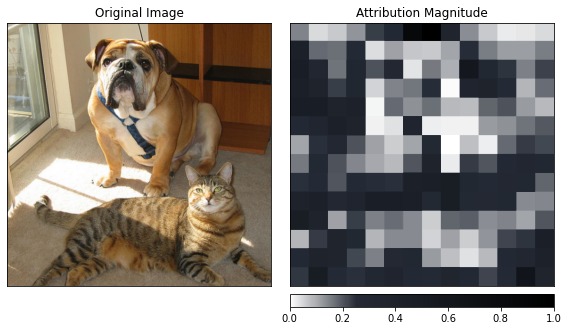

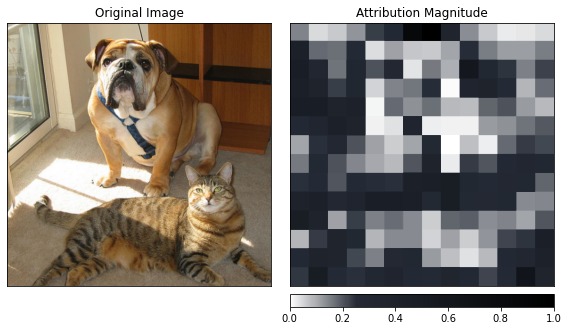

In [257]:
# the index of image in the test set. Please, change it if you want to play with different test images/samples.
image_idx = 3 # elephant
vqa_resnet_interpret(images[image_idx], [
    "what animal",
    "what animal",
], ['dog', 'cat'])

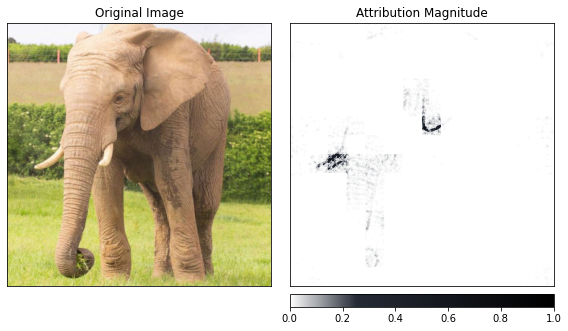

Text Contributions:  0.0
Image Contributions:  0.004025650210678577
Total Contribution:  0.004025650210678577


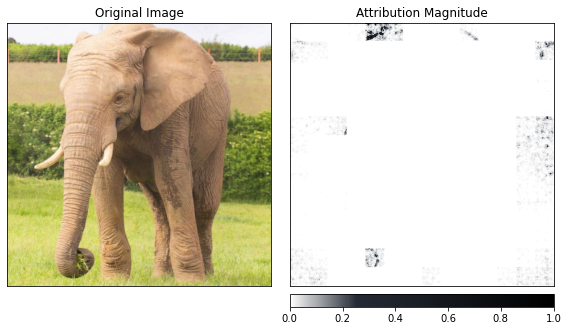

Text Contributions:  0.0
Image Contributions:  0.007193975616246462
Total Contribution:  0.007193975616246462


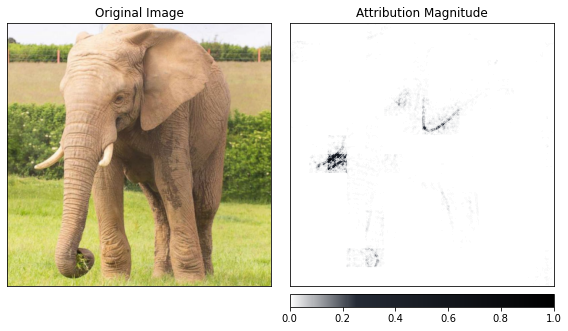

Text Contributions:  0.0
Image Contributions:  0.0016787962522357702
Total Contribution:  0.0016787962522357702


In [105]:
# the index of image in the test set. Please, change it if you want to play with different test images/samples.
image_idx = 1 # elephant
vqa_resnet_interpret(images[image_idx], [
    "what is on the picture",
    "what color is the elephant",
    "where is the elephant"
], ['elephant', 'gray', 'zoo'])

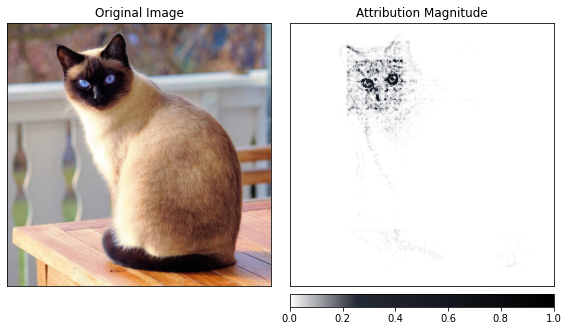

Text Contributions:  0.0
Image Contributions:  -1.267008900642395
Total Contribution:  -1.267008900642395


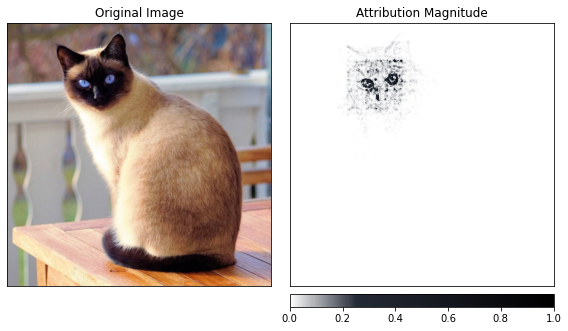

Text Contributions:  0.0
Image Contributions:  -2.411871910095215
Total Contribution:  -2.411871910095215


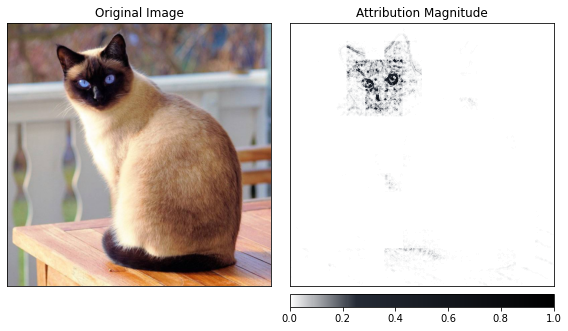

Text Contributions:  0.0
Image Contributions:  -0.4096149206161499
Total Contribution:  -0.4096149206161499


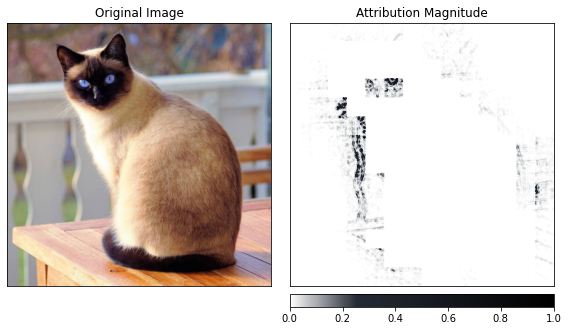

Text Contributions:  0.0
Image Contributions:  -0.029361262917518616
Total Contribution:  -0.029361262917518616


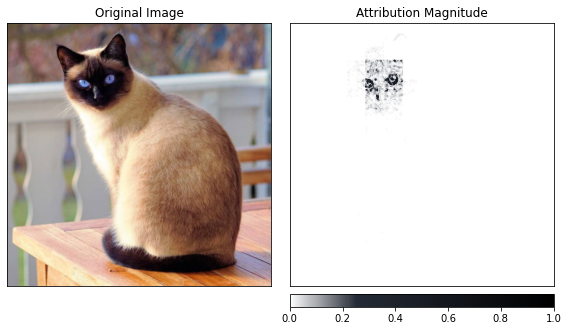

Text Contributions:  0.0
Image Contributions:  -1.505326271057129
Total Contribution:  -1.505326271057129


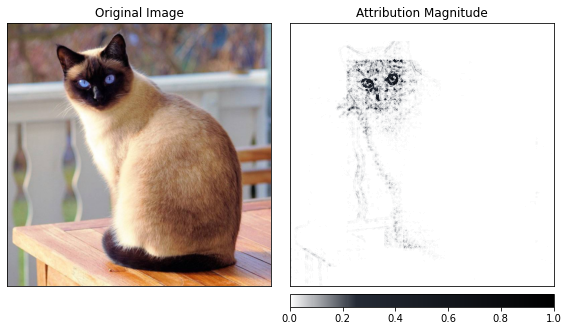

Text Contributions:  0.0
Image Contributions:  -2.135408401489258
Total Contribution:  -2.135408401489258


In [106]:
image_idx = 0 # cat

vqa_resnet_interpret(images[image_idx], [
    "what is on the picture",
    "what color are the cat's eyes",
    "is the animal in the picture a cat or a fox",
    "what color is the cat",
    "how many ears does the cat have",
    "where is the cat"
], ['cat', 'blue', 'cat', 'white and brown', '2', 'at the wall'])

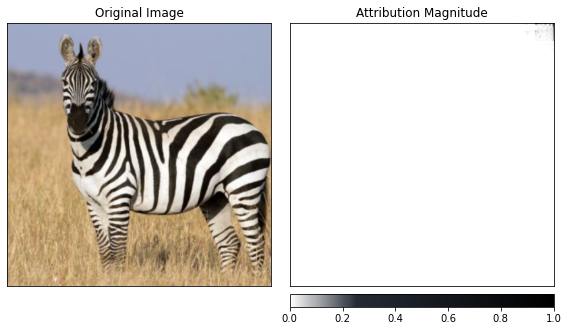

Text Contributions:  0.0
Image Contributions:  12.167806625366211
Total Contribution:  12.167806625366211


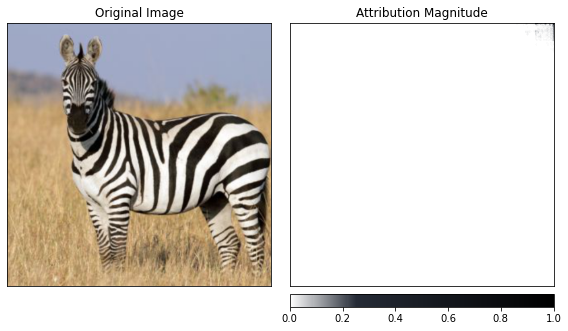

Text Contributions:  0.0
Image Contributions:  83.43873596191406
Total Contribution:  83.43873596191406


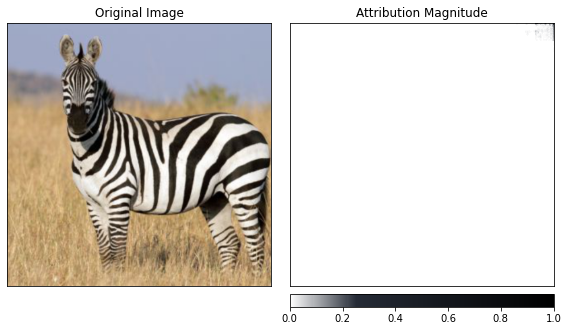

Text Contributions:  0.0
Image Contributions:  80.44768524169922
Total Contribution:  80.44768524169922


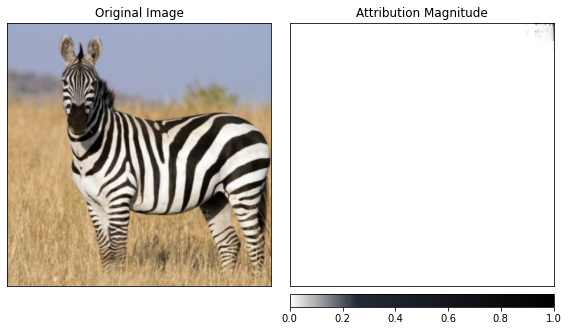

Text Contributions:  0.0
Image Contributions:  2.0485429763793945
Total Contribution:  2.0485429763793945


In [99]:
image_idx = 2 # zebra

vqa_resnet_interpret(images[image_idx], [
    "what is on the picture",
    "what color are the zebras",
    "how many zebras are on the picture",
    "where are the zebras"
], ['zebra', 'black and white', '2', 'zoo'])

As mentioned above, after we are done with interpretation, we have to remove Interpretable Embedding Layer and set the original embeddings layer back to the model.

In [58]:
if USE_INTEPRETABLE_EMBEDDING_LAYER:
    remove_interpretable_embedding_layer(vqa_resnet, interpretable_embedding)